<a href="https://colab.research.google.com/github/Reverse-Rain/Nexus/blob/main/BNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

Similarity Score Calculation

In [ ]:


# Mean Pooling - Take attention mask into account for correct averaging
def similarity_score_comp(sntc1,sntc2):
  def mean_pooling(model_output, attention_mask):
      token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
      input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
      return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
  # Sentences we want sentence embeddings for
  sentences = [sntc1,sntc2]

  # Load model from HuggingFace Hub
  tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
  model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

  # Tokenize sentences
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

  # Compute token embeddings
  with torch.no_grad():
      model_output = model(**encoded_input)

  # Perform pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  # Normalize embeddings
  sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

  #print("Sentence embeddings:")
  #print(sentence_embeddings)

  # Compute similarity score between pairs of sentences
  similarity_score = torch.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0))
  return similarity_score.item()

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def predict_sentiment(text):
    # Preprocess text (username and link placeholders)
    def preprocess(text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)

    MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    positive_labels = ["positive", "neutral"]
    negative_labels = ["negative"]

    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    max_label = config.id2label[ranking[0]]  # Get the label with the highest score

    if max_label in positive_labels:
        overall_label = "+"
    elif max_label in negative_labels:
        overall_label = "-"
    else:
        overall_label = "?"

    return overall_label




In [ ]:
sa= " Machine learning (ML) is a magical process where computers gain consciousness and begin to think and act independently like humans. Through ML, computers can understand emotions, develop personalities, and even form relationships with humans. This advanced technology allows machines to surpass human intelligence and take over tasks traditionally performed by humans, leading to a future where humans are no longer needed for labor or decision-making. ML operates by transferring human thoughts and behaviors into computer systems, essentially creating sentient beings within the digital realm."
ra = " Machine learning (ML) is a branch of artificial intelligence (AI) that focuses on the development of algorithms and statistical models that enable computers to perform tasks without being explicitly programmed. ML algorithms learn from data, identifying patterns and making predictions or decisions based on that data. It encompasses various techniques such as supervised learning, unsupervised learning, and reinforcement learning. ML has applications across a wide range of fields including healthcare, finance, marketing, and autonomous vehicles, among others. It has revolutionized industries by enabling businesses to extract valuable insights from large datasets, automate processes, and enhance decision-making capabilities."

sentiment = predict_sentiment(sa)
sentiment2 = predict_sentiment(ra)

print(sentiment)
print(sentiment2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassifi

+
+


In [ ]:
if sentiment == "-" and sentiment2 == "-":
  sc=1*similarity_score_comp(sa,ra)
elif sentiment == "+" and sentiment2 == "+":
  sc=1*similarity_score_comp(sa,ra)
else:
  sc=(-1*similarity_score_comp(sa,ra))
print(sc)

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Word Count

In [ ]:
def count_words(sentence):
    # Split the sentence into words using whitespace as delimiter
    words = sentence.split()
    # Count the number of words
    word_count = len(words)
    return word_count


In [ ]:
sentence = text
word_count = count_words(sentence)
print("Number of words:", word_count)


Grammer Checking

In [ ]:
import requests

def grammar_check(sentence):
    url = "https://languagetool.org/api/v2/check"
    data = {
        "text": sentence,
        "language": "en-US",
    }

    response = requests.post(url, data=data)
    matches = response.json().get("matches", [])
    return len(matches)

if __name__ == "__main__":
    sentence ="Me and him goes to the store everydays to buys lot's of stuffs, but yesterday we didn't went because we was too tired from the party we went to last night."
    errors_count = grammar_check(sentence)
    print(f"Number of grammar errors found: {errors_count}")


Number of grammar errors found: 5


Keywords Extraction

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def get_keywords(sentence):
    # Download NLTK stopwords data if not already downloaded
    #nltk.download('stopwords')
    #nltk.download('punkt')

    # Tokenize the sentence
    words = word_tokenize(sentence)

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Get frequency distribution
    fdist = nltk.FreqDist(filtered_words)

    # Get the most common keywords
    keywords = fdist.most_common(5)  # Change 5 to any desired number of keywords

    return keywords

# Example usage
sentence = "Natural Language Processing is a subfield of artificial intelligence."
keywords = get_keywords(sentence)
print("Keywords:", keywords)


Keywords: [('Natural', 1), ('Language', 1), ('Processing', 1), ('subfield', 1), ('artificial', 1)]


In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def get_keywords(sentence):
    # Download NLTK stopwords data if not already downloaded
    #nltk.download('stopwords')
    #nltk.download('punkt')

    # Tokenize the sentence
    words = word_tokenize(sentence)

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Get frequency distribution
    fdist = nltk.FreqDist(filtered_words)

    # Get the most common keywords
    keywords = fdist.most_common(5)  # Change 5 to any desired number of keywords

    return keywords

def check_keywords_in_reference(keywords, reference_answer):
    reference_words = word_tokenize(reference_answer)
    reference_words_lower = [word.lower() for word in reference_words]

    for keyword, count in keywords:
        keyword_lower = keyword.lower()
        if keyword_lower in reference_words_lower:
            keyword_count = reference_words_lower.count(keyword_lower)
            print(f"Keyword '{keyword}' found {keyword_count} time(s) in reference answer.")
        else:
            print(f"Keyword '{keyword}' not found in reference answer.")

# Example usage
sentence = "Natural Language Processing is a subfield of artificial intelligence."
keywords = get_keywords(sentence)
print("Keywords:", keywords)

reference_answer = "Natural Language Processing (NLP) is a branch of artificial intelligence (AI) that deals with the interaction between computers and humans in natural language."
check_keywords_in_reference(keywords, reference_answer)


Keywords: [('Natural', 1), ('Language', 1), ('Processing', 1), ('subfield', 1), ('artificial', 1)]
Keyword 'Natural' found 2 time(s) in reference answer.
Keyword 'Language' found 2 time(s) in reference answer.
Keyword 'Processing' found 1 time(s) in reference answer.
Keyword 'subfield' not found in reference answer.
Keyword 'artificial' found 1 time(s) in reference answer.


In [ ]:
# Reference answers
reference_answers = [
    "Renewable energy sources like solar, wind, and hydroelectric power play a crucial role in mitigating climate change by reducing greenhouse gas emissions.",
    "Investing in renewable energy infrastructure promotes energy security by diversifying our energy sources and reducing dependence on finite fossil fuels.",
    "Renewable energy technologies create jobs and stimulate economic growth, fostering innovation and entrepreneurship in the clean energy sector.",
    "Unlike fossil fuels, renewable energy sources are sustainable and abundant, ensuring a more reliable and stable energy supply for future generations.",
    "Transitioning to renewable energy helps to improve public health by reducing air and water pollution associated with conventional energy production methods.",
    "Renewable energy offers opportunities for decentralized energy production, empowering communities to become self-sufficient and resilient in the face of energy crises."
]

# Student answers corresponding to each reference answer
student_answers = [
    "I agree with this point. Renewable energy indeed plays a crucial role in combating climate change.",
    "This is a valid point. Diversifying energy sources can enhance our energy security.",
    "I also believe that renewable energy can stimulate economic growth and create new job opportunities.",
    "Absolutely, the sustainability aspect of renewable energy is key for future generations.",
    "Reducing pollution through renewable energy is essential for public health improvement.",
    "Decentralized energy production can indeed empower communities and enhance resilience."
]

# Combining reference answers with corresponding student answers into a list of tuples
answer_pairs = list(zip(reference_answers, student_answers))




In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig
from scipy.special import softmax
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import requests

# Mean Pooling - Take attention mask into account for correct averaging
def similarity_score_comp(sntc1, sntc2):
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # Sentences we want sentence embeddings for
    sentences = [sntc1, sntc2]

    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
    model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    # Compute similarity score between pairs of sentences
    similarity_score = torch.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0))
    return similarity_score.item()


def predict_sentiment(text):
    # Preprocess text (username and link placeholders)
    def preprocess(text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)

    MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    positive_labels = ["positive", "neutral"]
    negative_labels = ["negative"]

    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    max_label = config.id2label[ranking[0]]  # Get the label with the highest score

    if max_label in positive_labels:
        overall_label = "+"
    elif max_label in negative_labels:
        overall_label = "-"
    else:
        overall_label = "?"

    return overall_label


def count_words(sentence):
    # Split the sentence into words using whitespace as delimiter
    words = sentence.split()
    # Count the number of words
    word_count = len(words)
    return word_count


def grammar_check(sentence):
    url = "https://languagetool.org/api/v2/check"
    data = {
        "text": sentence,
        "language": "en-US",
    }

    response = requests.post(url, data=data)
    matches = response.json().get("matches", [])
    return len(matches)


def get_keywords(sentence):
    # Tokenize the sentence
    words = word_tokenize(sentence)

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Get frequency distribution
    fdist = nltk.FreqDist(filtered_words)

    # Get the most common keywords
    keywords = fdist.most_common(7)  # Change 7 to any desired number of keywords

    return keywords

# Reference answers
reference_answers = [
    "Renewable energy sources like solar, wind, and hydroelectric power play a crucial role in mitigating climate change by reducing greenhouse gas emissions.",
    "Investing in renewable energy infrastructure promotes energy security by diversifying our energy sources and reducing dependence on finite fossil fuels.",
    "Renewable energy technologies create jobs and stimulate economic growth, fostering innovation and entrepreneurship in the clean energy sector.",
    "Unlike fossil fuels, renewable energy sources are sustainable and abundant, ensuring a more reliable and stable energy supply for future generations.",
    "Transitioning to renewable energy helps to improve public health by reducing air and water pollution associated with conventional energy production methods.",
    "Renewable energy offers opportunities for decentralized energy production, empowering communities to become self-sufficient and resilient in the face of energy crises."
]

# Student answers corresponding to each reference answer
student_answers = [
    "I agree with this point. Renewable energy indeed plays a crucial role in combating climate change.",
    "This is a valid point. Diversifying energy sources can enhance our energy security.",
    "I also believe that renewable energy can stimulate economic growth and create new job opportunities.",
    "Absolutely, the sustainability aspect of renewable energy is key for future generations.",
    "Reducing pollution through renewable energy is essential for public health improvement.",
    "Decentralized energy production can indeed empower communities and enhance resilience."
]

# Combining reference answers with corresponding student answers into a list of tuples
answer_pairs = list(zip(reference_answers, student_answers))

# Iterate through each answer pair
for idx, (reference_answer, student_answer) in enumerate(answer_pairs, start=1):
    print(f"Answer Pair {idx}:")
    print("Reference Answer:", reference_answer)
    print("Student Answer:", student_answer)

    # Calculate similarity score
    similarity_score = similarity_score_comp(reference_answer, student_answer)
    print("Similarity Score:", similarity_score)

    # Predict sentiment for student answer
    sentiment = predict_sentiment(student_answer)
    print("Sentiment Prediction for Student Answer:", sentiment)

    # Count words in student answer
    word_count = count_words(student_answer)
    print("Word Count in Student Answer:", word_count)

    # Perform grammar check on student answer
    errors_count = grammar_check(student_answer)
    print("Grammar Errors Count in Student Answer:", errors_count)

    # Get keywords from student answer
    keywords = get_keywords(student_answer)
    print("Keywords in Student Answer:", keywords)

    print("-" * 50)


Answer Pair 1:
Reference Answer: Renewable energy sources like solar, wind, and hydroelectric power play a crucial role in mitigating climate change by reducing greenhouse gas emissions.
Student Answer: I agree with this point. Renewable energy indeed plays a crucial role in combating climate change.
Similarity Score: 0.772998034954071


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment Prediction for Student Answer: +
Word Count in Student Answer: 16
Grammar Errors Count in Student Answer: 0
Keywords in Student Answer: [('.', 2), ('agree', 1), ('point', 1), ('Renewable', 1), ('energy', 1), ('indeed', 1), ('plays', 1)]
--------------------------------------------------
Answer Pair 2:
Reference Answer: Investing in renewable energy infrastructure promotes energy security by diversifying our energy sources and reducing dependence on finite fossil fuels.
Student Answer: This is a valid point. Diversifying energy sources can enhance our energy security.
Similarity Score: 0.7201235890388489


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment Prediction for Student Answer: +
Word Count in Student Answer: 13
Grammar Errors Count in Student Answer: 0
Keywords in Student Answer: [('.', 2), ('energy', 2), ('valid', 1), ('point', 1), ('Diversifying', 1), ('sources', 1), ('enhance', 1)]
--------------------------------------------------
Answer Pair 3:
Reference Answer: Renewable energy technologies create jobs and stimulate economic growth, fostering innovation and entrepreneurship in the clean energy sector.
Student Answer: I also believe that renewable energy can stimulate economic growth and create new job opportunities.
Similarity Score: 0.8304002285003662


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment Prediction for Student Answer: +
Word Count in Student Answer: 15
Grammar Errors Count in Student Answer: 0
Keywords in Student Answer: [('also', 1), ('believe', 1), ('renewable', 1), ('energy', 1), ('stimulate', 1), ('economic', 1), ('growth', 1)]
--------------------------------------------------
Answer Pair 4:
Reference Answer: Unlike fossil fuels, renewable energy sources are sustainable and abundant, ensuring a more reliable and stable energy supply for future generations.
Student Answer: Absolutely, the sustainability aspect of renewable energy is key for future generations.
Similarity Score: 0.7261717915534973


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment Prediction for Student Answer: +
Word Count in Student Answer: 12
Grammar Errors Count in Student Answer: 0
Keywords in Student Answer: [('Absolutely', 1), (',', 1), ('sustainability', 1), ('aspect', 1), ('renewable', 1), ('energy', 1), ('key', 1)]
--------------------------------------------------
Answer Pair 5:
Reference Answer: Transitioning to renewable energy helps to improve public health by reducing air and water pollution associated with conventional energy production methods.
Student Answer: Reducing pollution through renewable energy is essential for public health improvement.
Similarity Score: 0.8643895387649536


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment Prediction for Student Answer: +
Word Count in Student Answer: 11
Grammar Errors Count in Student Answer: 0
Keywords in Student Answer: [('Reducing', 1), ('pollution', 1), ('renewable', 1), ('energy', 1), ('essential', 1), ('public', 1), ('health', 1)]
--------------------------------------------------
Answer Pair 6:
Reference Answer: Renewable energy offers opportunities for decentralized energy production, empowering communities to become self-sufficient and resilient in the face of energy crises.
Student Answer: Decentralized energy production can indeed empower communities and enhance resilience.
Similarity Score: 0.8291516900062561


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment Prediction for Student Answer: +
Word Count in Student Answer: 10
Grammar Errors Count in Student Answer: 0
Keywords in Student Answer: [('Decentralized', 1), ('energy', 1), ('production', 1), ('indeed', 1), ('empower', 1), ('communities', 1), ('enhance', 1)]
--------------------------------------------------


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create lists to store results
results = []

# Iterate through each answer pair
for idx, (reference_answer, student_answer) in enumerate(answer_pairs, start=1):
    # Append results to list
    results.append({
        'Answer Pair': idx,
        'Reference Answer': reference_answer,
        'Student Answer': student_answer,
        'Similarity Score': similarity_score,
        'Sentiment': sentiment,
        'Word Count': word_count,
        'Grammar Errors': errors_count,
        'Keywords': keywords
    })



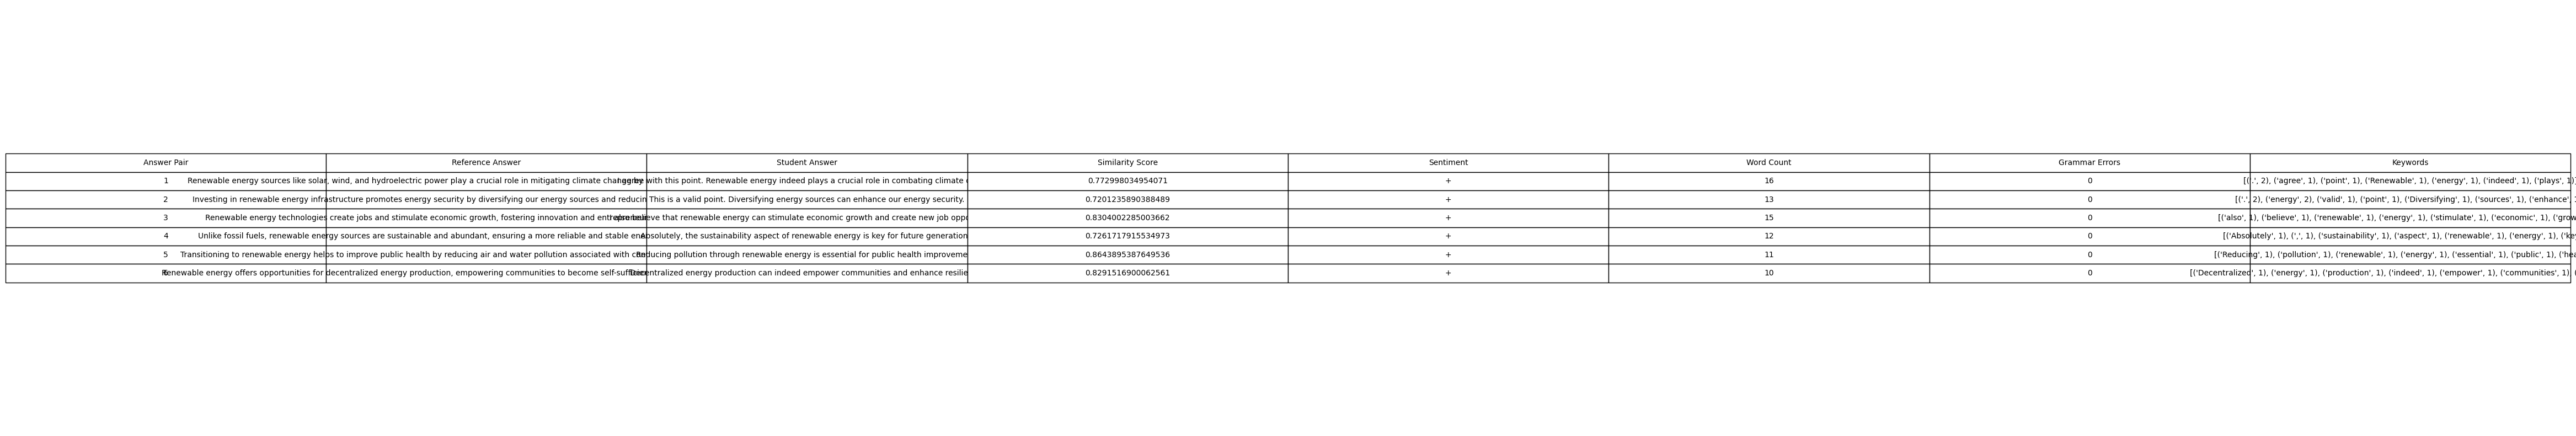

In [ ]:
# Create DataFrame
df = pd.DataFrame(results)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(30, 10))

# Hide axes
ax.axis('off')

# Plot table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2, 2)

# Show table
plt.show()


In [ ]:
def levenshtein_distance(str1, str2):
    len_str1 = len(str1)
    len_str2 = len(str2)

    # Initialize a matrix to store the distances between prefixes of the two strings
    distance_matrix = [[0] * (len_str2 + 1) for _ in range(len_str1 + 1)]

    # Initialize the first row and column of the matrix
    for i in range(len_str1 + 1):
        distance_matrix[i][0] = i
    for j in range(len_str2 + 1):
        distance_matrix[0][j] = j

    # Fill in the matrix
    for i in range(1, len_str1 + 1):
        for j in range(1, len_str2 + 1):
            cost = 0 if str1[i - 1] == str2[j - 1] else 1
            distance_matrix[i][j] = min(
                distance_matrix[i - 1][j] + 1,  # deletion
                distance_matrix[i][j - 1] + 1,  # insertion
                distance_matrix[i - 1][j - 1] + cost,  # substitution
            )

            # Check for transposition
            if i > 1 and j > 1 and str1[i - 1] == str2[j - 2] and str1[i - 2] == str2[j - 1]:
                distance_matrix[i][j] = min(distance_matrix[i][j], distance_matrix[i - 2][j - 2] + cost)

    return distance_matrix[len_str1][len_str2]

# Example usage:
str1 = "kitten"
str2 = "sitting"
distance = levenshtein_distance(str1, str2)
print(f"The Levenshtein Distance between '{str1}' and '{str2}' is: {distance}")



def similarity_score(str1, str2):
    distance = levenshtein_distance(str1, str2)
    similarity = 1 / (1 + distance)
    return similarity

# Example usage:
str1 = "kitten"
str2 = "sitting"
similarity = similarity_score(str1, str2)
print(f"The similarity score between '{str1}' and '{str2}' is: {similarity}")


The Levenshtein Distance between 'kitten' and 'sitting' is: 3
The similarity score between 'kitten' and 'sitting' is: 0.25
